# Project - Airline AI Assistant multi-modal agentic framework

We add an agentic framework to our tool based AI Customer Support assistant for an Airline

In [44]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
import gradio as gr

In [47]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")
    
MODEL = "gpt-4o-mini"
MODEL_ANTHROPIC = "claude-3-haiku-20240307"
openai = OpenAI()
claude = anthropic.Anthropic()


OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-


In [4]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

history looks like this
[
    {"role": "user", "content": "Hi"},
    {"role": "assistant", "content": "Hello! How can I help?"},
    {"role": "user", "content": "Tell me a joke"},
    {"role": "assistant", "content": "Why did the chicken cross the road..."}
]

In [5]:
# Chat interface
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


## Tools

With tools, we can write a function, and have the LLM call that function as part of its response.

In [6]:
# Function for ticket prices
# This function simulates a tool that provides ticket prices for different destinations.

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [7]:
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [8]:
# Function for booking flights
# This function simulates a tool that books flights for a given destination.
def book_flight(destination_city, date):
    print(f"Tool book_flight called for {destination_city} on {date}")
    city = destination_city.lower()
    if city in ticket_prices:
        return f"Flight to {destination_city} on {date} booked successfully!"
    else:
        return "Booking failed: Unknown destination."


In [9]:
book_flight("Berlin", "2023-10-01")

Tool book_flight called for Berlin on 2023-10-01


'Flight to Berlin on 2023-10-01 booked successfully!'

In [10]:
# Describe our tool functions:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

booking_function = {
    "name": "book_flight",
    "description": "Book a flight to the destination city on a specific date. Call this whenever a customer wants to book a flight, for example when they say 'Book me a flight to this city on this date'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
            "date": {
                "type": "string",
                "description": "The date of the flight in YYYY-MM-DD format",
            },
        },
        "required": ["destination_city", "date"],
        "additionalProperties": False
    }
}

In [11]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}, 
         {"type": "function", "function": booking_function}]

## Getting OpenAI to use our Tools

We allow OpenAI "to call our tools".

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tools.

## Handle a single tool call message in a model response

In [ ]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls": #stop response and call tool
        message = response.choices[0].message #collect request to run the tool
        if message.tool_calls[0].function.name == "get_ticket_price":
            response, city = handle_tool_call_price(message)
        elif message.tool_calls[0].function.name == "book_flight":
            response, city = handle_tool_call_booking(message) #collect response from tool
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages) #send back to LLM
    
    return response.choices[0].message.content

In [13]:
# We have to write that function handle_tool_call:
# The function takes a single tool call message in a model response, not muliple tool calls.
# This function unpacks the message from the LLM, extracts the tool available, and executes the function with the provided arguments.

def handle_tool_call_price(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id #links the response to the tool call
    }
    return response, city

def handle_tool_call_booking(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    date = arguments.get('date')
    booking_response = book_flight(city, date)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city, "date": date, "booking_response": booking_response}),
        "tool_call_id": tool_call.id #links the response to the tool call
    }
    return response, city


In [14]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7875
* To create a public link, set `share=True` in `launch()`.


## Handle multiple tool calls message in a single response

In [35]:
def chat_multi(message, history):
    messages = (
        [{"role": "system", "content": system_message}]
        + history
        + [{"role": "user", "content": message}]
    )

    response = openai.chat.completions.create(
        model=MODEL,
        messages=messages,
        tools=tools
    )
    assistant_msg = response.choices[0].message

    # Respond to ALL tools
    if getattr(assistant_msg, "tool_calls", None):
        tool_messages = []
        cities = []

        for tool_call in assistant_msg.tool_calls:
            tool_msg, city = dispatch_tool_call(tool_call)
            tool_messages.append(tool_msg)      
            if city:
                cities.append(city)

        # Append the assistant message (with tool_calls) and all tool messages
        messages.append({
            "role": "assistant",
            "content": assistant_msg.content or "",
            "tool_calls": assistant_msg.tool_calls
        })
        messages.extend(tool_messages)

        # Continue conversation so the model can use tool outputs
        response2 = openai.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools  # keep tools available in case model chains more calls
        )
        return response2.choices[0].message.content

    # No tool calls—just return the assistant’s content
    return assistant_msg.content

In [36]:
def dispatch_tool_call(tool_call):
    name = tool_call.function.name
    arguments = json.loads(tool_call.function.arguments or "{}")

    city = None
    if name == "get_ticket_price":
        city = arguments.get("destination_city")
        price = get_ticket_price(city)
        tool_response = {"destination_city": city, "price": price}

    elif name == "book_flight":
        city = arguments.get("destination_city")
        date = arguments.get("date")
        booking_response = book_flight(city, date)
        tool_response = {"destination_city": city, "date": date, "booking_response": booking_response}

    else:
        tool_response = {"error": f"Unknown tool '{name}'", "arguments": arguments}

    tool_msg = {
        "role": "tool",
        "tool_call_id": tool_call.id,
        "content": json.dumps(tool_response)
    }
    return tool_msg, city


In [37]:
gr.ChatInterface(fn=chat_multi, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7882
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Berlin
Tool book_flight called for Berlin on 2026-01-01


# Let's go multi-modal

We use DALL-E-3, the image generation model behind GPT-4o  as an agent, to make us some images and put this in a function called draw. We use tts-1 text-to-speech model as an agent to convert each LLM response to audio. We use Claude model as an agent to translate each GPT-4o response to german. We use an additional agent to convert audio input to text.

## Image generation agent

In [67]:
import base64
from io import BytesIO
from PIL import Image

def draw(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

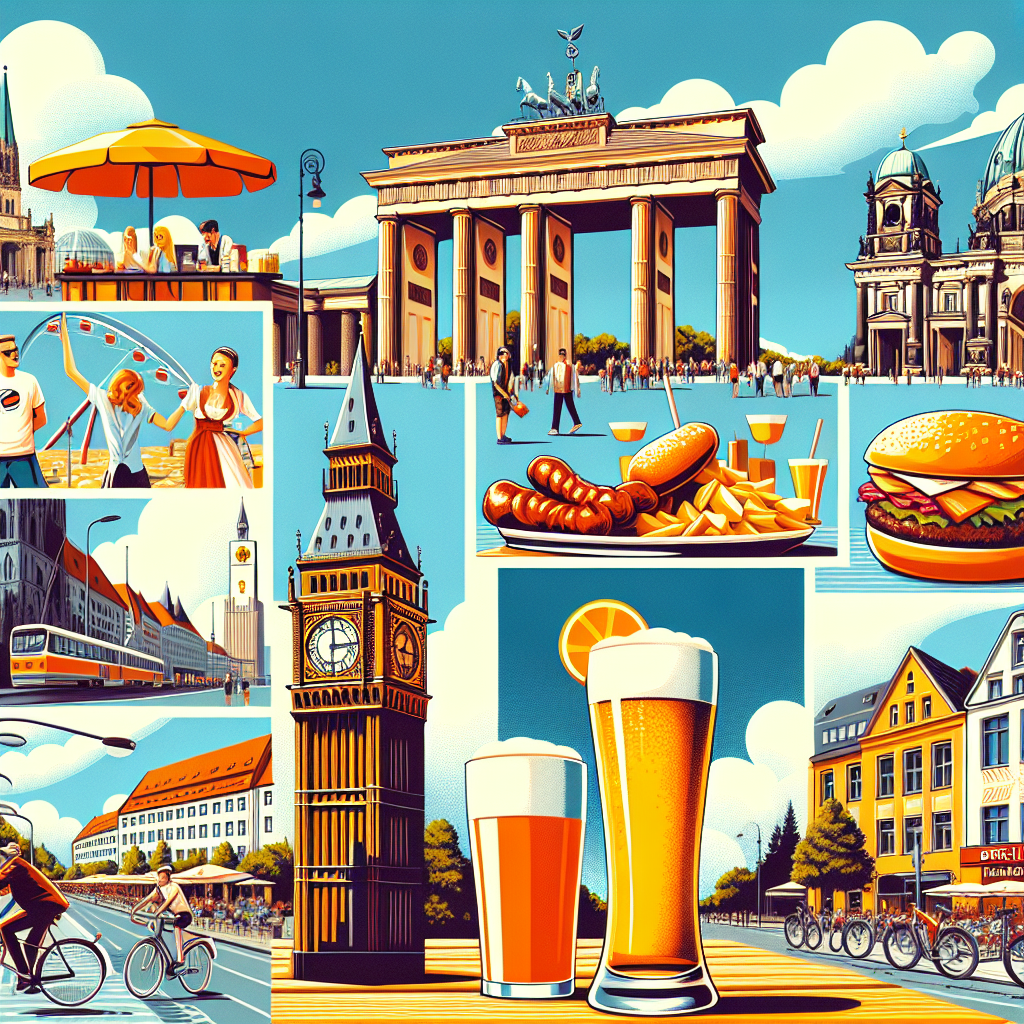

In [50]:
image = draw("Berlin")
display(image)

## Text to speech agent

In [51]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",   # Different voice: alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [52]:
talker("Well, hi Maryline, you are a wonderful AI Engineer")

Input #0, wav, from '/var/folders/_y/s_lpp18512x_2mns_tm6v_wc0000gn/T/tmpaq1uth9y.wav':
  Duration: 00:00:03.10, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


## Language translation agent

In [58]:
def translate(message, target_language):
    message = claude.messages.create(
    model=MODEL_ANTHROPIC,
    max_tokens=200,
    temperature=0.7,
    system="You are a helpful translator",
    messages=[
        {"role": "user", "content": f"Translate this to {target_language}: {message}"}
    ]
    )
    return message.content[0].text


## Speech to text agent 

In [64]:
def transcribe(audio_file_path: str) -> str:
    if not audio_file_path:
        return ""
    with open(audio_file_path, "rb") as f:
        text = openai.audio.transcriptions.create(
            model="whisper-1",
            file=f,
            response_format="text"
        )
    return text

# Our Agent Framework

The following points are touched here:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate


### Single tool call pro response

In [59]:
def chat_with_agent(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    if response.choices[0].finish_reason=="tool_calls": #stop response and call tool
        message = response.choices[0].message #collect request to run the tool
        if message.tool_calls[0].function.name == "get_ticket_price":
            response, city = handle_tool_call_price(message)
        elif message.tool_calls[0].function.name == "book_flight":
            response, city = handle_tool_call_booking(message) #collect response from tool
        messages.append(message)
        messages.append(response)
        image = draw(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages) #send back to LLM
    
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # audio response
    talker(reply)
    translation = translate(reply, "German")
    
    return history, image, translation

### Multiple tool calls pro response

In [ ]:
def chat_multi_with_agent(history):
    history = history or []
    messages = [{"role": "system", "content": system_message}] + history 

    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    assistant_msg = response.choices[0].message

    image = None  

    if getattr(assistant_msg, "tool_calls", None):
        tool_messages = []
        cities = []

        for tool_call in assistant_msg.tool_calls:
            tool_msg, city = dispatch_tool_call(tool_call)
            tool_messages.append(tool_msg)
            if city:
                cities.append(city)

        # append assistant (with tool_calls) + all tool messages
        messages.append({
            "role": "assistant",
            "content": assistant_msg.content or "",
            "tool_calls": assistant_msg.tool_calls
        })
        messages.extend(tool_messages)

        # draw city
        if cities:
            image = draw(cities[-1])  

        # continue so model can use tool outputs
        response2 = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
        reply = response2.choices[0].message.content or ""
        history.append({"role":"assistant","content":reply})
        talker(reply)
        translation = translate(reply, "German")
        return history, image, translation

    # no tool calls
    reply = assistant_msg.content or ""
    history.append({"role":"assistant","content":reply})
    talker(reply)
    translation = translate(reply, "German")
    return history, image, translation


In [66]:
# Gradio Chat interface

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
        translation_output = gr.Textbox(label="Translation to German", placeholder="Translation will appear here", lines=2)
    with gr.Row():
        text_entry = gr.Textbox(label="Chat with our AI Assistant:")
        audio_entry = gr.Audio(sources=["microphone"], type="filepath", label="Or speak to our AI assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, audio, history):
        if message:
            history += [{"role":"user", "content":message}]
        if audio:
            history += [{"role":"user", "content":transcribe(audio)}]
        return "", None, history

    text_entry.submit(do_entry, inputs=[text_entry, audio_entry, chatbot], outputs=[text_entry, audio_entry, chatbot]).then(
        chat_with_agent, inputs=chatbot, outputs=[chatbot, image_output, translation_output]
    )
    audio_entry.change(do_entry, inputs=[text_entry, audio_entry, chatbot], outputs=[text_entry, audio_entry, chatbot]).then(
        chat_with_agent, inputs=chatbot, outputs=[chatbot, image_output, translation_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7904
* To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/_y/s_lpp18512x_2mns_tm6v_wc0000gn/T/tmpi3fxna6t.wav':
  Duration: 00:00:02.04, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/_y/s_lpp18512x_2mns_tm6v_wc0000gn/T/tmpphvzfbdm.wav':
  Duration: 00:00:04.20, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool book_flight called for Berlin on 2026-01-01


Input #0, wav, from '/var/folders/_y/s_lpp18512x_2mns_tm6v_wc0000gn/T/tmpamy9y73s.wav':
  Duration: 00:00:05.23, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
